In [1]:
# num_latents sets both the number of multiplicative and additive latents

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scienceplots
import os, pickle

import torch

from spks import viz
from spks import event_aligned as ea

from joblib import Parallel, delayed

from lib import data, spks_utils, fitlvm_utils, fit_models, models, utils

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

### First pass for one session

In [ ]:
# print("Loading Data")
# trial_data_r_all, trial_data_all, session_data_all, unit_spike_times_all, regions_all = data.load_data(thresh=1) # 1m 15s

Loading Data
Subject: MM012
> Session: 20231211_172819
> Session: 20231218_170114
> Session: 20231221_134112
> Session: 20231222_145357
> Session: 20231225_123125
Subject: MM013
> Session: 20231218_175023
> Session: 20231220_142345
> Session: 20231222_141517
> Session: 20231225_130825
> Session: 20231227_132538


In [ ]:
# out = fit_models.fit_all_latents_gs(trial_data_all, session_data_all, unit_spike_times_all, regions_all, max_n_latents=8) # 230m 32s
# das = [[[out[subj_idx][sess_idx][latent_idx][0] for latent_idx in range(8)] for sess_idx in range(len(data.session_ids[subj_idx]))] for subj_idx in range(len(data.subject_ids))]
# np.save('das_gs_011526.npy', das)
# das_ = np.load('das_gs_011526.npy', allow_pickle=True)
# assert all([utils.list_dict_equiv(das[i], das_[i]) for i in range(len(das))]) # True

Fitting Models


In [4]:
das = np.load('vars/das_gs_011526.npy', allow_pickle=True)

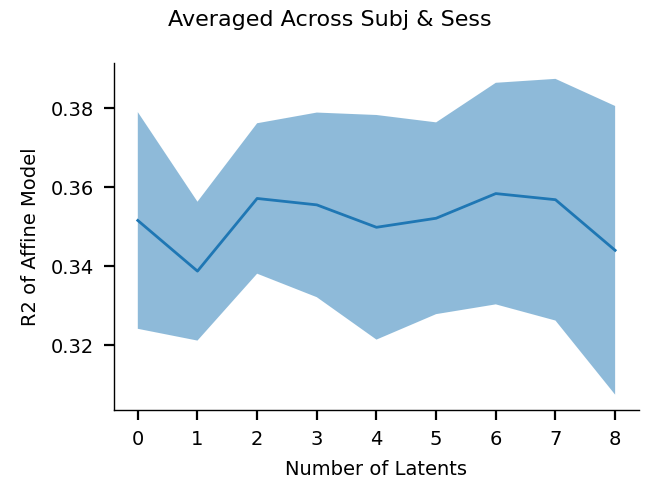

In [6]:
r2s_tv = np.mean(np.array([[torch.mean(das_sess[i]['tv']['r2test']) for i in range(len(das_sess))] for das_subj in das for das_sess in das_subj]),axis=0)
r2s_affine = np.array([[torch.mean(das_sess[i]['affine']['r2test']) for i in range(len(das_sess))] for das_subj in das for das_sess in das_subj])

r2s_tv_avg = np.array([np.mean(r2s_affine)])
r2s_tv_std = np.array([np.std(r2s_affine)])

r2s_affine_avg = np.concatenate((r2s_tv_avg, np.mean(r2s_affine, axis=0)))
r2s_affine_std = np.concatenate((r2s_tv_std, np.std(r2s_affine, axis=0)))

fig, ax = plt.subplots()

ax.plot(range(0,9), r2s_affine_avg)
ax.fill_between(range(0,9), r2s_affine_avg+r2s_affine_std, r2s_affine_avg-r2s_affine_std, alpha=0.5)
ax.set_xlabel("Number of Latents"); ax.set_ylabel("R2 of Affine Model")
fig.suptitle(f"Averaged Across Subj & Sess")
fig.tight_layout()
fig.show()

# plt.savefig(f"figs/r2s_latents/affine_avg.png")

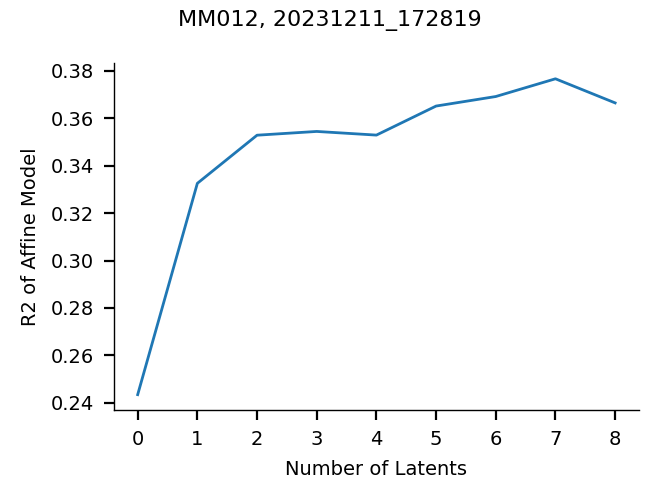

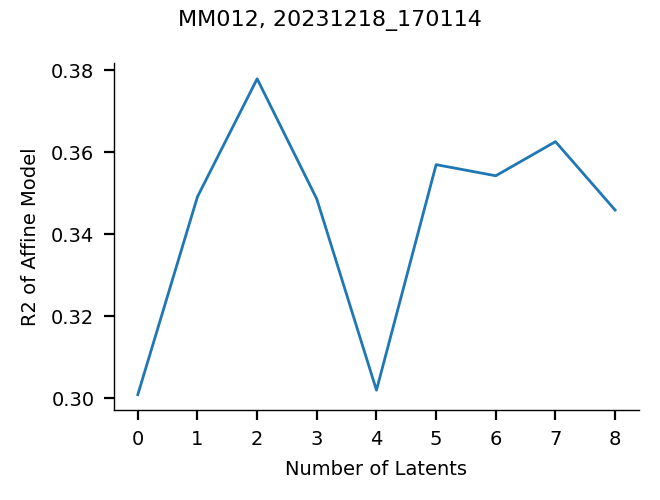

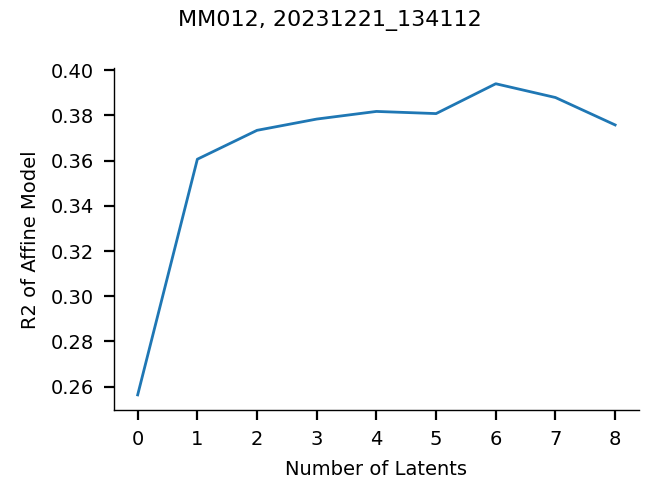

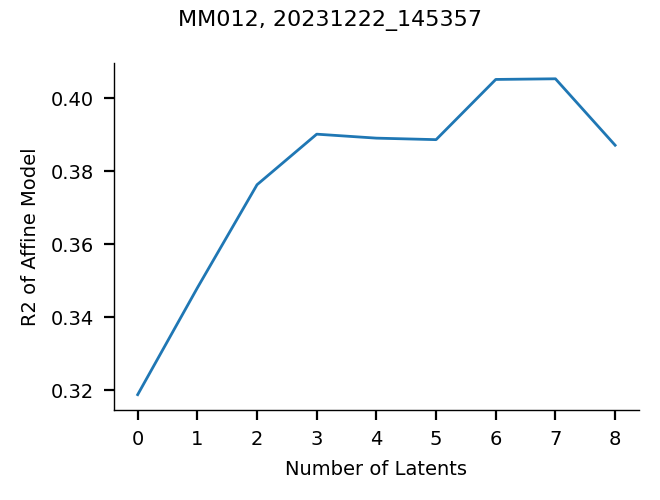

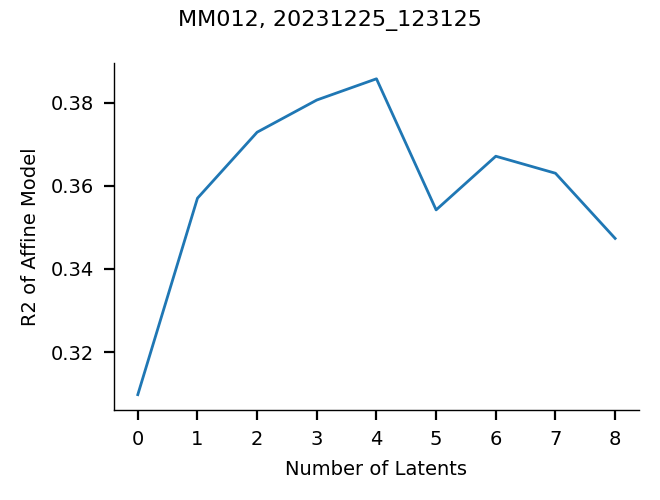

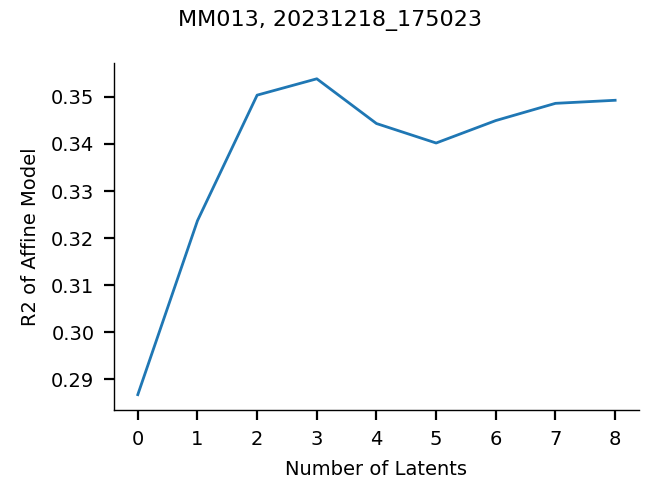

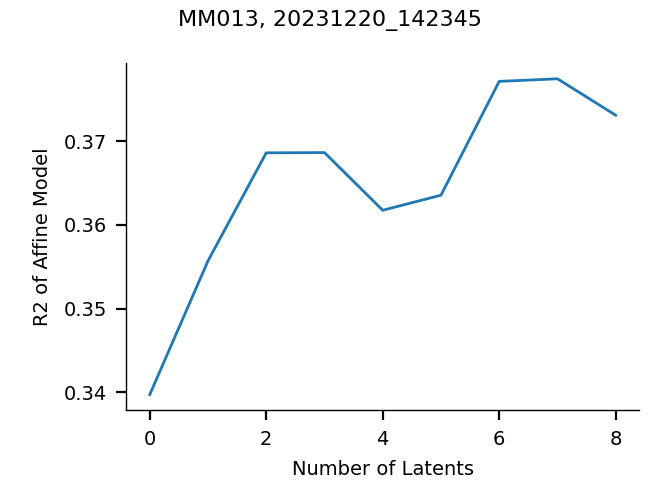

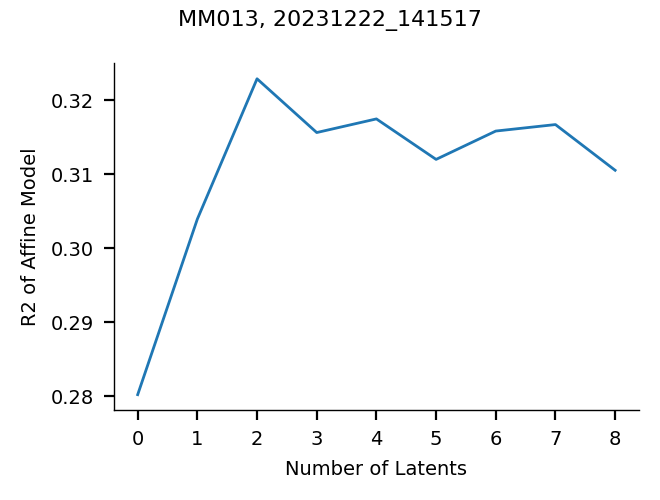

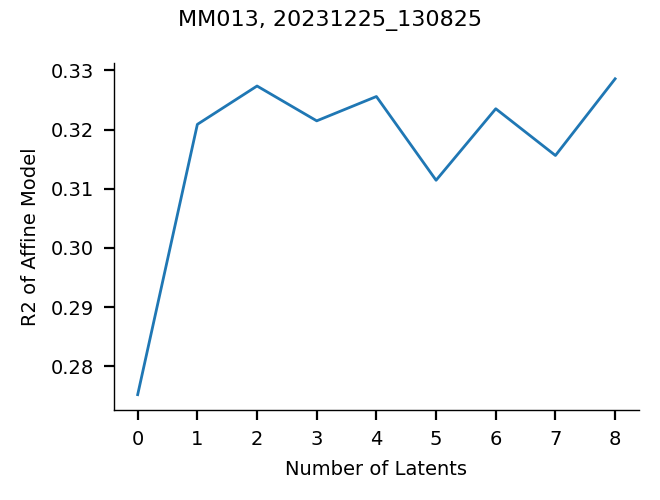

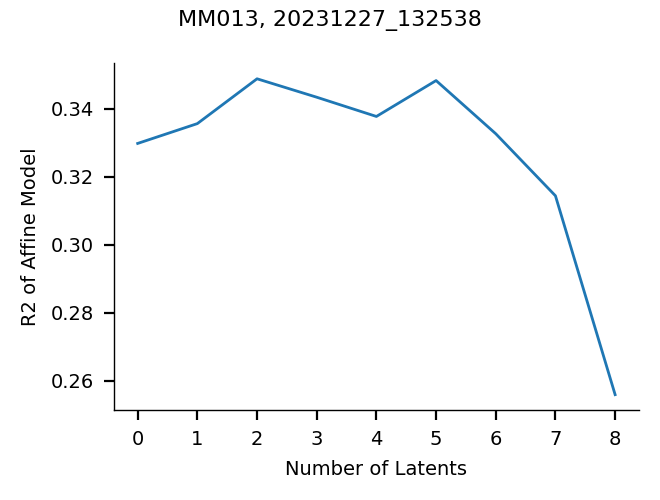

In [25]:
for subj_idx, das_subj in enumerate(das):
    for sess_idx, das_sess in enumerate(das_subj):  
        r2s_tv = [np.mean([torch.mean(das_sess[i]['tv']['r2test']) for i in range(len(das_sess))])]
        r2s_affine = [torch.mean(das_sess[i]['affine']['r2test']) for i in range(len(das_sess))]

        fig, ax = plt.subplots()
        ax.plot(range(0,9), np.concatenate((r2s_tv,r2s_affine)))
        ax.set_xlabel("Number of Latents"); ax.set_ylabel("R2 of Affine Model")
        fig.suptitle(f"{data.subject_ids[subj_idx]}, {data.session_ids[subj_idx][sess_idx]}")
        fig.tight_layout()
        #fig.show()
        plt.savefig(f"figs/r2s_latents/affine_{data.subject_ids[subj_idx]}-{data.session_ids[subj_idx][sess_idx]}.png")

## One Session

In [35]:
out = Parallel(n_jobs=8, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times, trial_data, session_data, regions, subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,10))

In [43]:
das  = [out[latent_idx][0] for latent_idx in range(8)]
figs = [out[latent_idx][1] for latent_idx in range(8)]
assert all([das[latent_idx]['affine']['model'].gain_mu.get_weights().shape[1] for latent_idx in range(len(das))] == np.arange(1,9))

In [52]:
coupling = das[1]['affine']['model'].readout_gain.weight.data[:].T

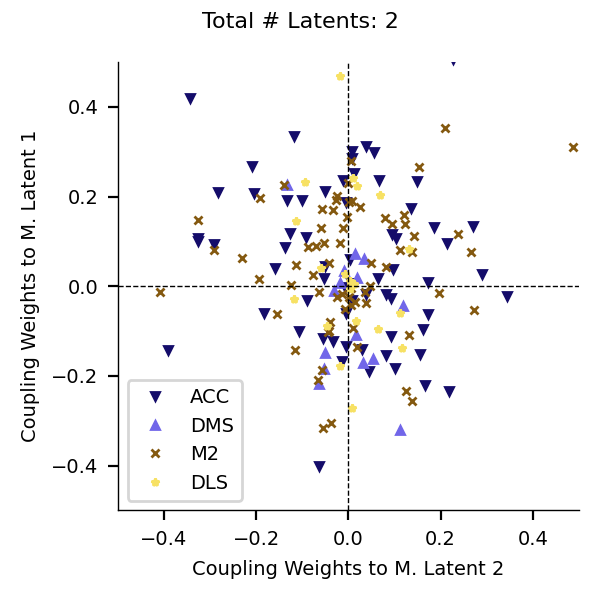

In [99]:
num_latents=2
foo(ax0=0, ax1=1)

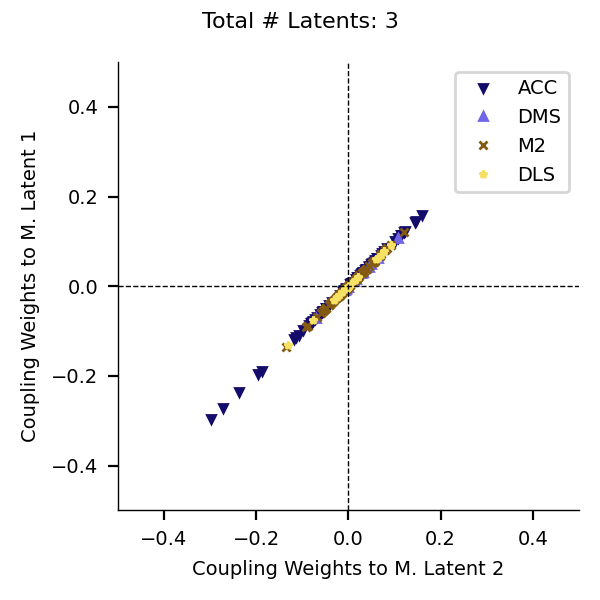

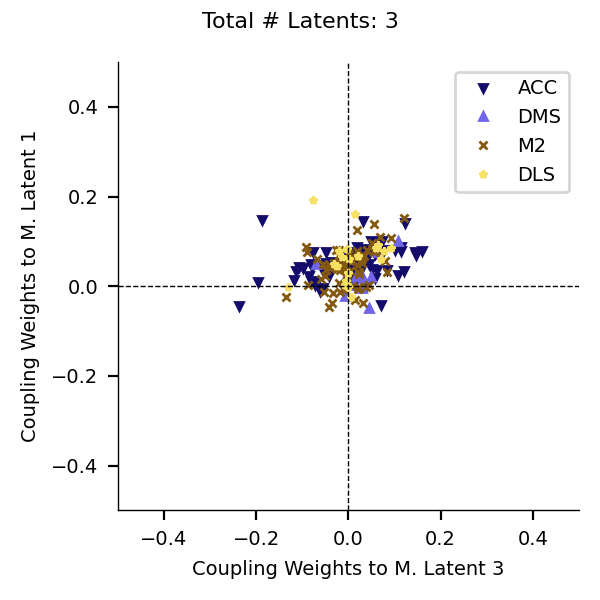

In [98]:
num_latents=3
foo(ax0=0, ax1=1)
foo(ax0=0, ax1=2)

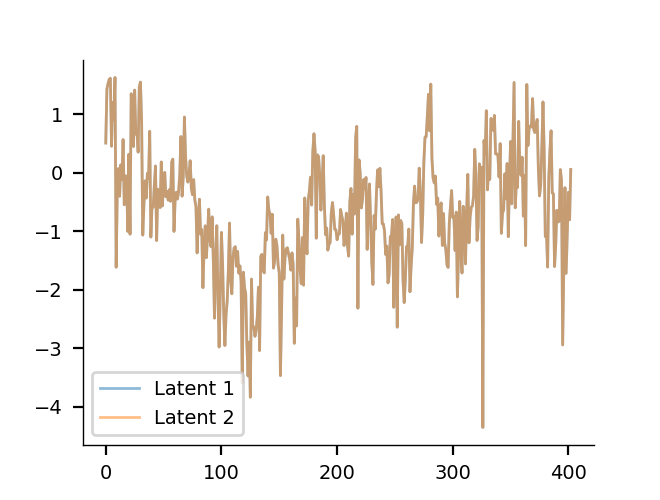

In [114]:
plt.plot(das[2]['affine']['model'].gain_mu.get_weights()[:,0], alpha=0.5, label="Latent 1")
plt.plot(das[2]['affine']['model'].gain_mu.get_weights()[:,1], alpha=0.5, label="Latent 2")
plt.legend()

In [77]:
reg = 'ACC'
idxs = np.where(reg_keys==0)[0]
coupling_reg = coupling[idxs]
coupling_reg[:,0] == coupling_reg[:,1]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True])

In [7]:
def foo(ax0, ax1):
    markers = ['v', '^', 'x', '*']
    colors = ["#140C6A", "#7166E9", "#845910", "#F7E164"]

    cids = das[num_latents-1]['affine']['model'].cids
    coupling = das[num_latents-1]['affine']['model'].readout_gain.weight.data[:].T

    regs = das[num_latents-1]['data']['regions']
    reg_keys = das[num_latents-1]['data']['reg_keys'][cids]

    fig, ax = plt.subplots(figsize=(3,3))

    for i, reg in enumerate(regs):
        idxs = np.where(reg_keys==i)[0]
        coupling_reg = coupling[idxs]
        ax.plot(coupling_reg[:,ax0], coupling_reg[:,ax1], markers[i], color=colors[i], label=reg)
        #ax.axhline(torch.mean(coupling_reg), color=colors[i], linewidth=0.3, linestyle='--')

    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_ylabel(f'Coupling Weights to M. Latent {ax0+1}'); ax.set_xlabel(f"Coupling Weights to M. Latent {ax1+1}")
    fig.suptitle(f"Total # Latents: {num_latents}")
    
    ax.set_ylim([-0.5,0.5])
    ax.set_xlim([-0.5,0.5])

    ax.legend()
    fig.tight_layout()
    fig.show()

foo(ax0=4, ax1=5)

NameError: name 'num_latents' is not defined

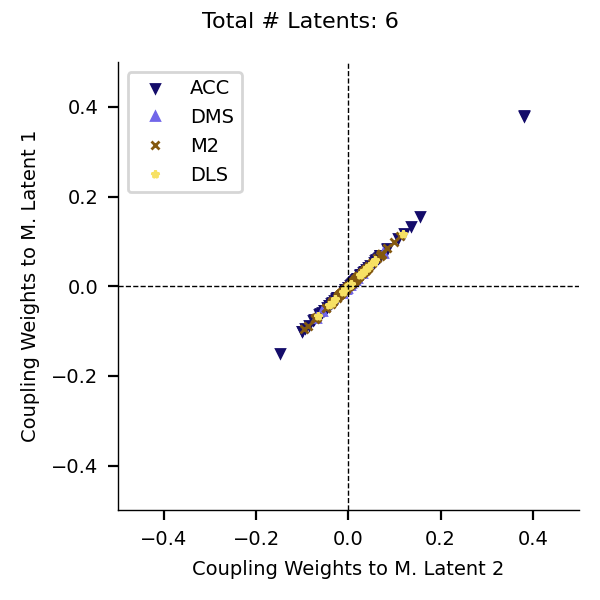

In [95]:
foo(ax0=0, ax1=1)

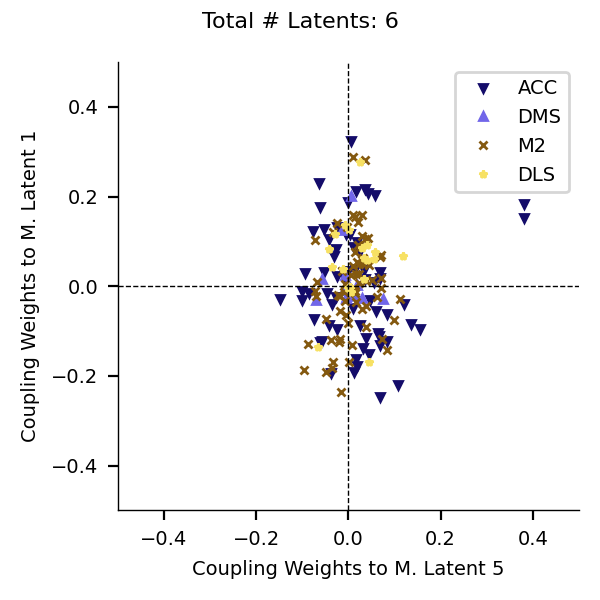

In [96]:
foo(ax0=0, ax1=4)

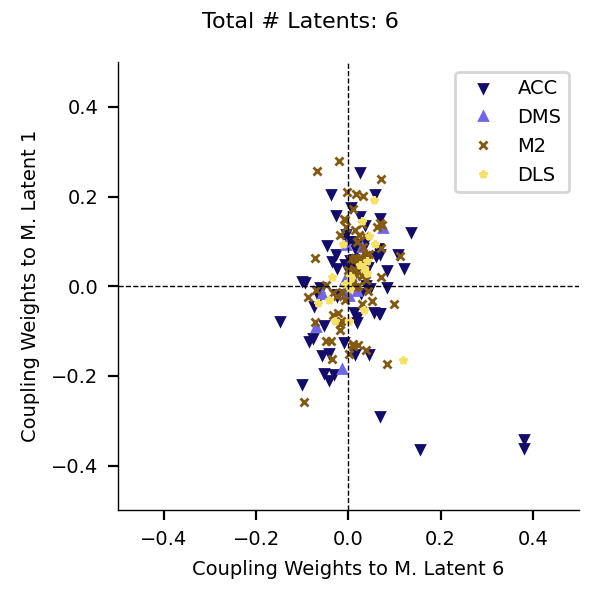

In [116]:
num_latents=6
foo(ax0=0, ax1=5)

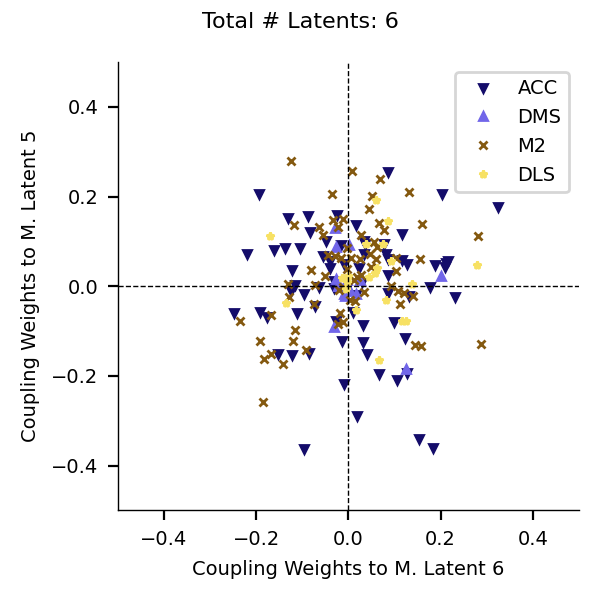

In [117]:
num_latents=6
foo(ax0=4, ax1=5)

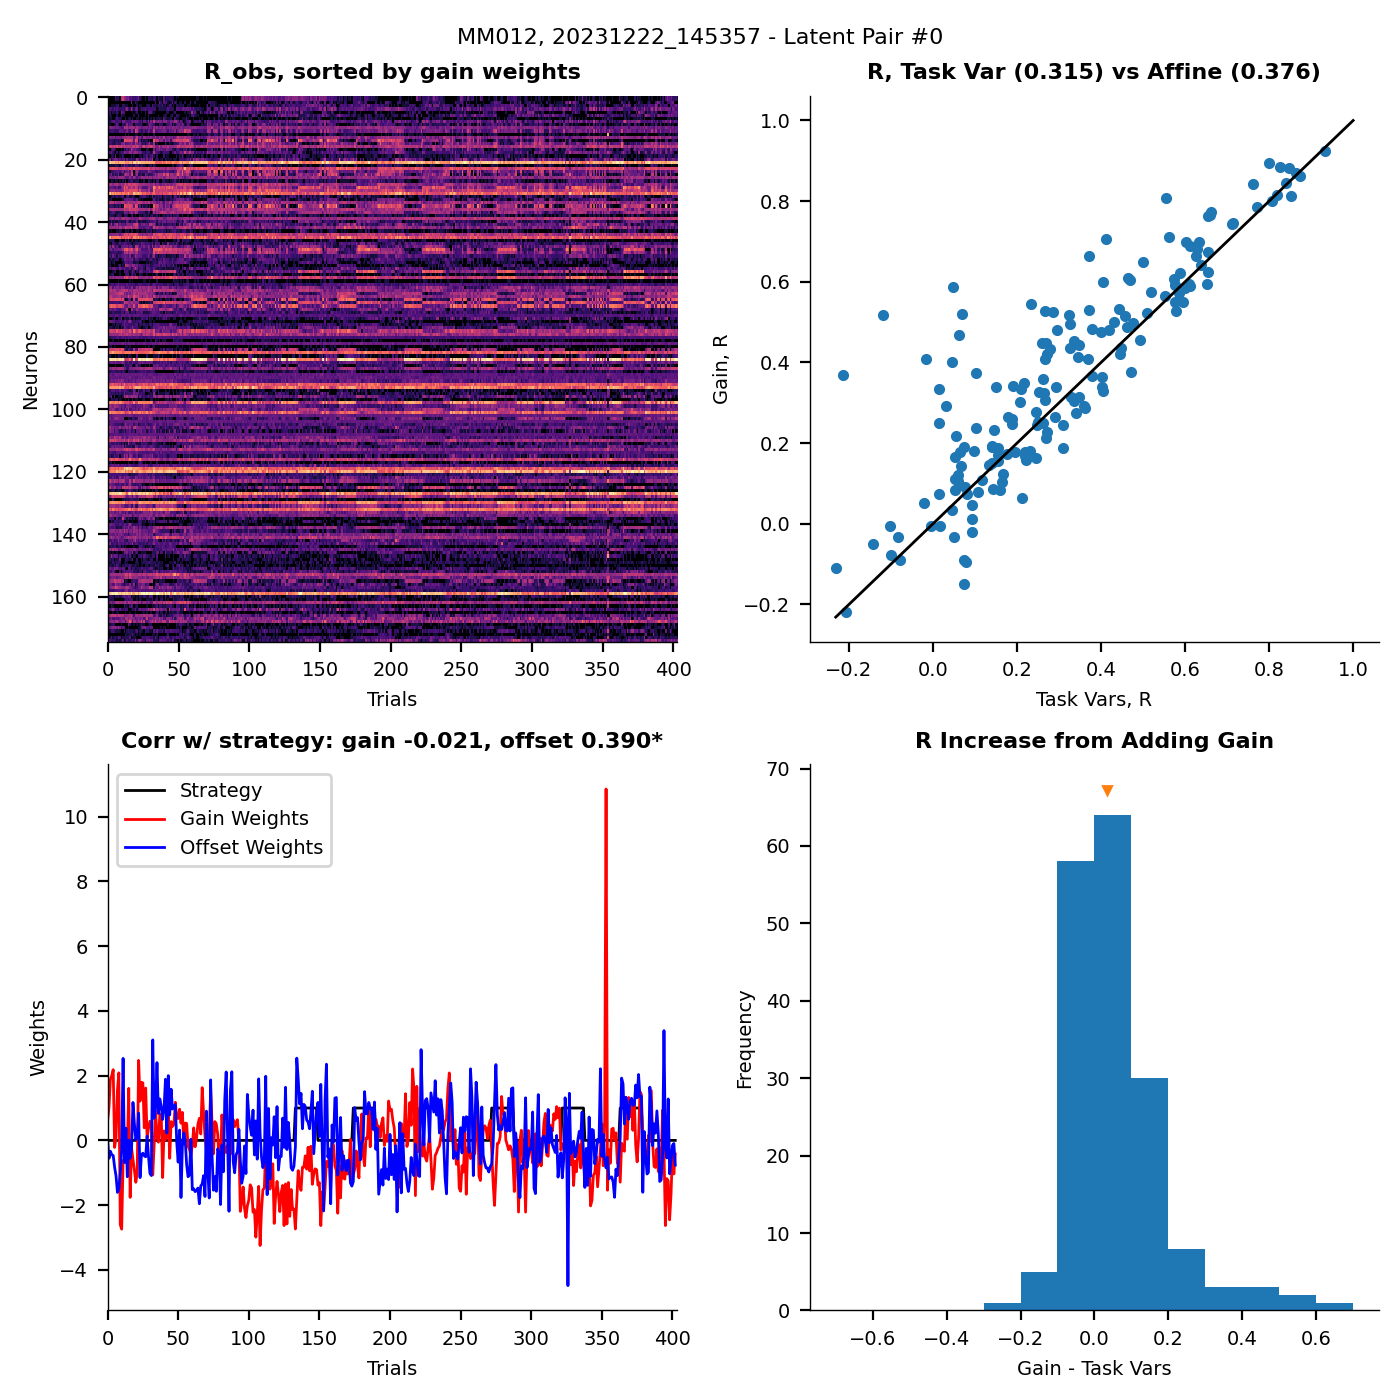

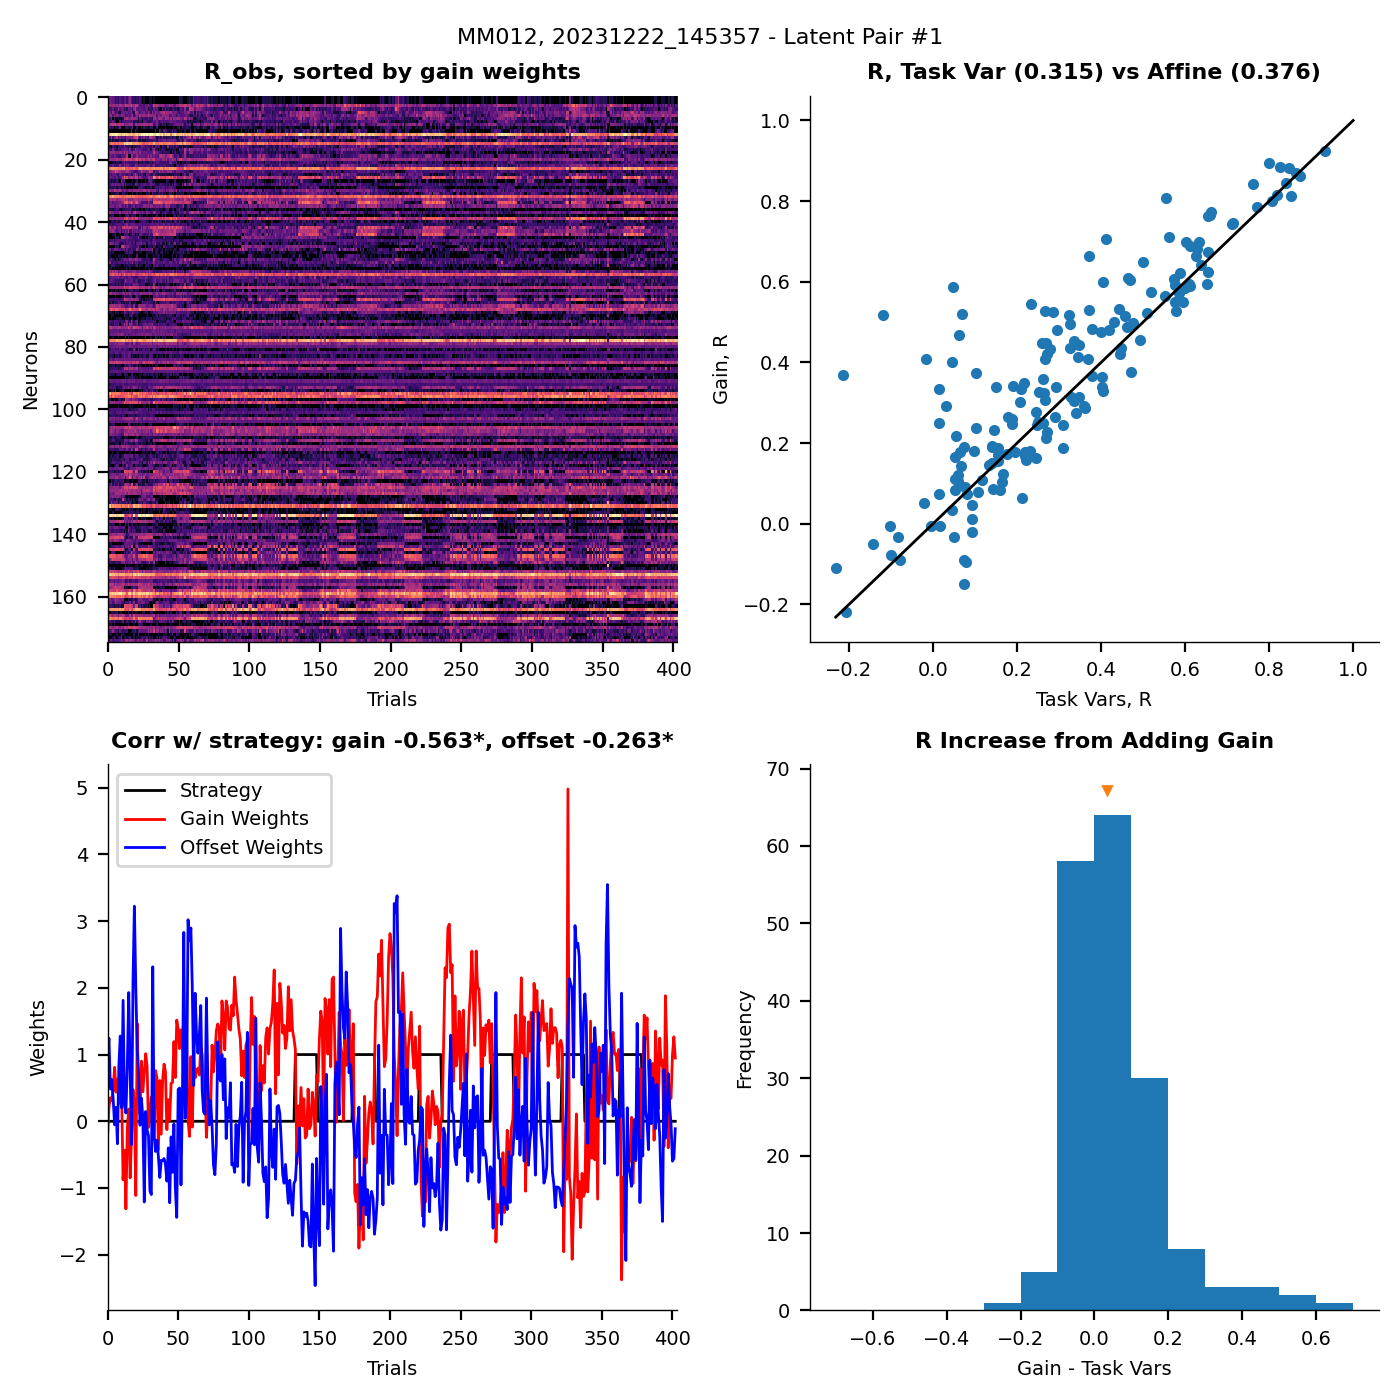

In [51]:
_ = fitlvm_utils.plot_summary(das[1], subj_idx=subj_idx, sess_idx=sess_idx)

### Grid Search

In [ ]:
trial_data_r_all, trial_data_all, session_data_all, unit_spike_times_all, regions_all = data.load_data(thresh=1) # 1m 15s

Subject: MM012
> Session: 20231211_172819
> Session: 20231218_170114
> Session: 20231221_134112
> Session: 20231222_145357
> Session: 20231225_123125
Subject: MM013
> Session: 20231218_175023
> Session: 20231220_142345
> Session: 20231222_141517
> Session: 20231225_130825
> Session: 20231227_132538


In [3]:
def fit_sess_latents_gs(subj_idx, sess_idx):
    return Parallel(n_jobs=8, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,8+1))

In [7]:
# out = fit_sess_latents_gs(subj_idx=0, sess_idx=3) # 230m 32s
# das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('das_03_latents.npy', das)

In [34]:
# das = np.load('vars/das_03_latents.npy', allow_pickle=True)
das = np.load('vars/das_gs_011526.npy', allow_pickle=True)
das=das[0][3]

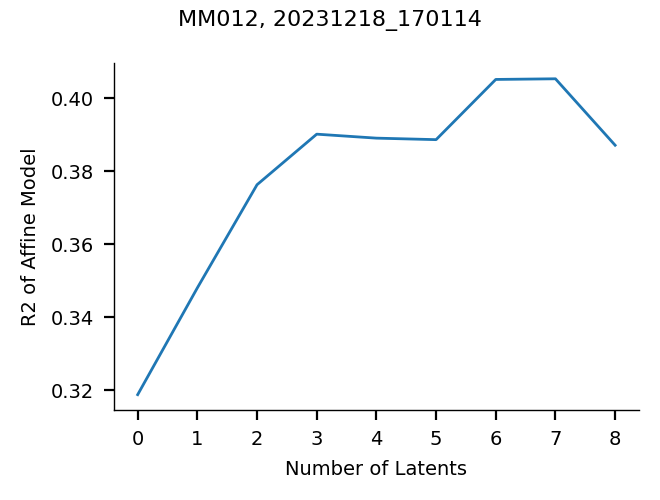

In [35]:
r2s_tv = [np.mean([torch.mean(das[i]['tv']['r2test']) for i in range(len(das))])]
r2s_affine = [torch.mean(das[i]['affine']['r2test']) for i in range(len(das))]

fig, ax = plt.subplots()
ax.plot(range(0,9), np.concatenate((r2s_tv,r2s_affine)))
ax.set_xlabel("Number of Latents"); ax.set_ylabel("R2 of Affine Model")
fig.suptitle(f"{data.subject_ids[0]}, {data.session_ids[0][1]}")
fig.tight_layout()

In [37]:
def foo(ax0, ax1, num_latents, abort=True):
    markers = ['v', '^', 'x', '*']
    colors = ["#140C6A", "#7166E9", "#845910", "#F7E164"]

    cids = das[num_latents-1]['affine']['model'].cids
    coupling = das[num_latents-1]['affine']['model'].readout_offset.weight.data[:].T

    # coupling = das[num_latents-1]['affine']['model'].readout_gain.weight.data[:].T

    regs = das[num_latents-1]['data']['regions']
    reg_keys = das[num_latents-1]['data']['reg_keys'][cids]
    
    
    if abort and all([all(coupling[np.where(reg_keys==i)[0],ax0] == coupling[np.where(reg_keys==i)[0],ax1]) for i in reg_keys]):
        print(f"Latent {ax0+1} and Latent {ax1+1} are equal, aborting")
        return

    fig, ax = plt.subplots(figsize=(3,3))

    for i, reg in enumerate(regs):
        idxs = np.where(reg_keys==i)[0]
        coupling_reg = coupling[idxs]
        ax.plot(coupling_reg[:,ax0], coupling_reg[:,ax1], markers[i], color=colors[i], label=reg)
        #ax.axhline(torch.mean(coupling_reg), color=colors[i], linewidth=0.3, linestyle='--')

    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel(f'Latent {ax0+1}'); ax.set_ylabel(f"Latent {ax1+1}")
    fig.suptitle(f"Total # Latents: {num_latents}")
    
    ax.set_ylim([-0.5,0.5])
    ax.set_xlim([-0.5,0.5])

    ax.legend()
    fig.tight_layout()
    fig.show()
    
def bah(ax0, ax1, num_latents):
    plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax0], alpha=0.5, label=f"Latent {ax0+1}")
    plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax1], alpha=0.5, label=f"Latent {ax1+1}")
    plt.legend()

Latent 1 and Latent 2 are equal, aborting
Latent 1 and Latent 3 are equal, aborting
Latent 2 and Latent 3 are equal, aborting


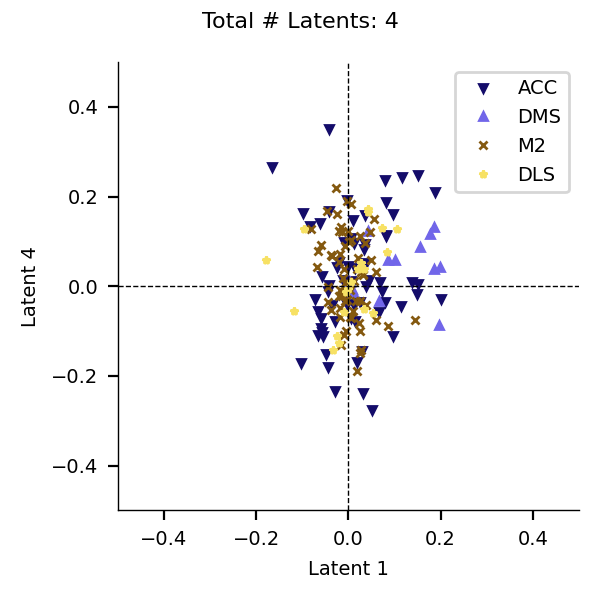

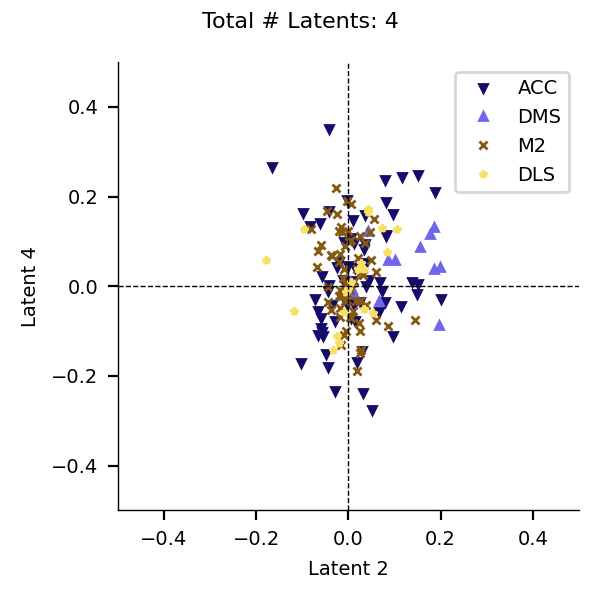

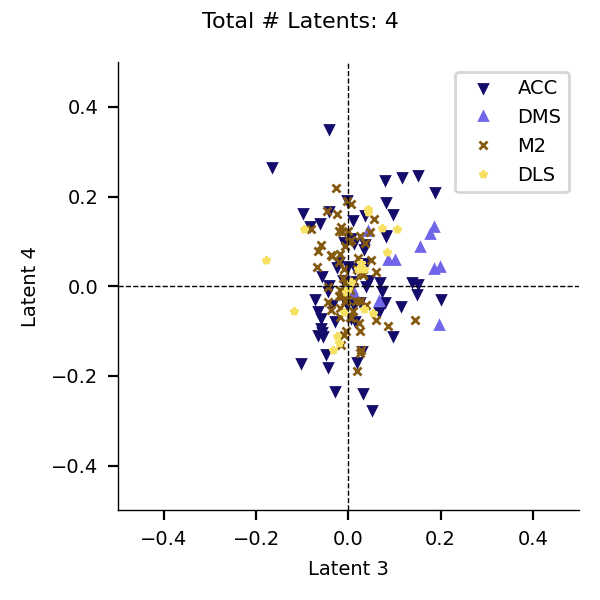

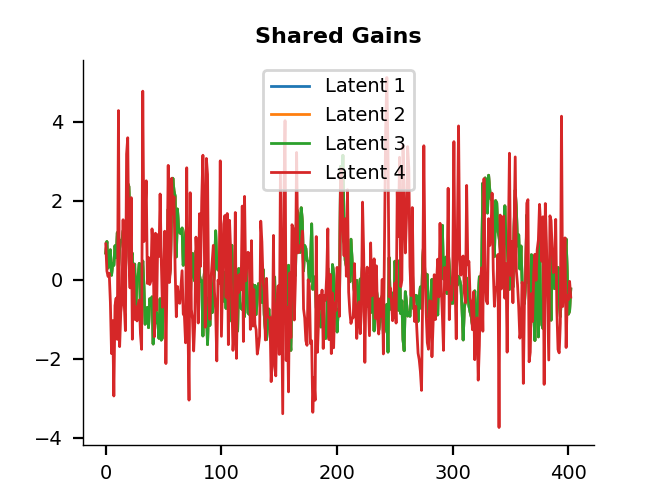

In [39]:
for ax0 in range(4):
    for ax1 in range(4):
        if ax0 < ax1:
            foo(ax0=ax0, ax1=ax1, num_latents=4)

num_latents=4

plt.figure()
for ax in range(4):
    plt.plot(das[num_latents-1]['affine']['model'].offset_mu.get_weights()[:,ax], label=f"Latent {ax+1}")
    
    #plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax], label=f"Latent {ax+1}")
    
plt.title("Shared Gains")
plt.legend()

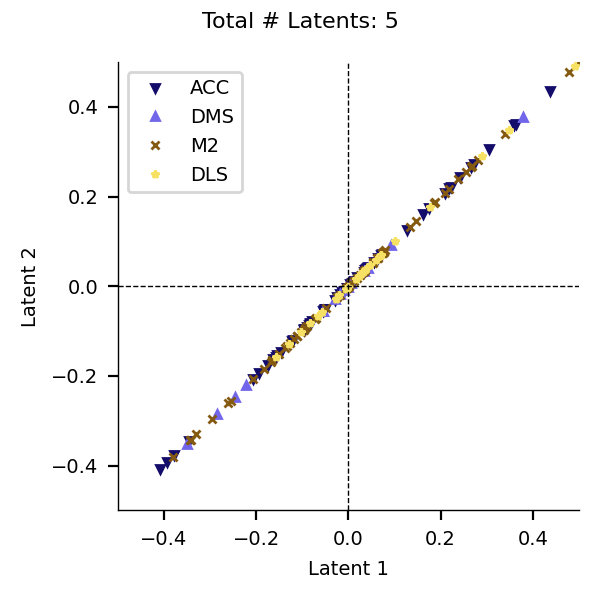

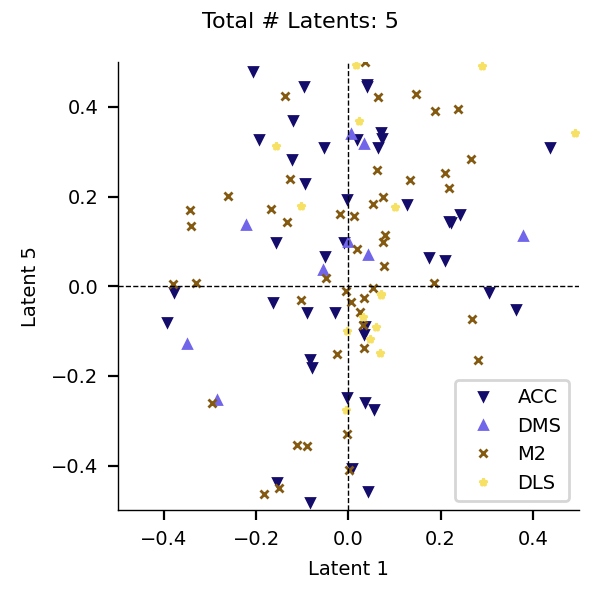

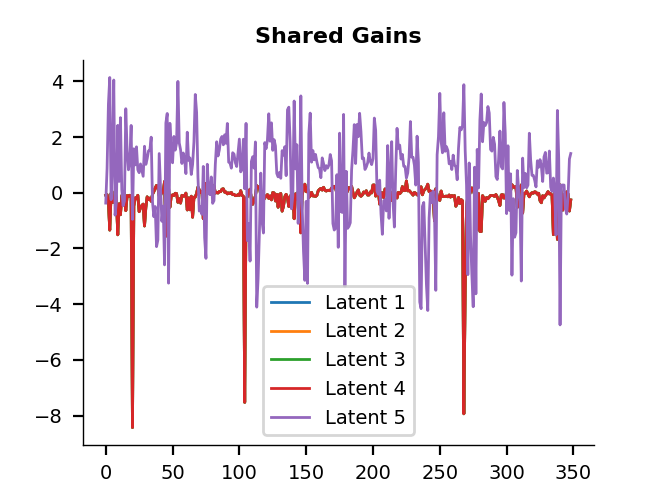

In [32]:
foo(ax0=0, ax1=1, num_latents=5, abort=False)
foo(ax0=0, ax1=4, num_latents=5)

num_latents=5

plt.figure()
for ax in range(5):
    plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax], label=f"Latent {ax+1}")
    
plt.title("Shared Gains")
plt.legend()

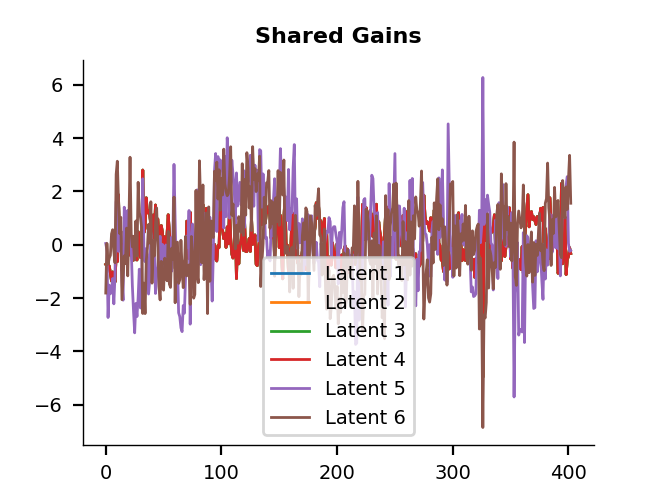

In [29]:
# latents = 6 (3 uniques)
# for ax0 in range(6):
#     for ax1 in range(6):
#         if not ax0>=ax1: foo(ax0=ax0, ax1=ax1, num_latents=6)

# foo(ax0=0, ax1=1, num_latents=6, abort=False)
# foo(ax0=0, ax1=4, num_latents=6)
# foo(ax0=0, ax1=5, num_latents=6)
# foo(ax0=4, ax1=5, num_latents=6)

num_latents=6

for ax in range(6):
    plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax], label=f"Latent {ax+1}")
    
plt.title("Shared Gains")
plt.legend()

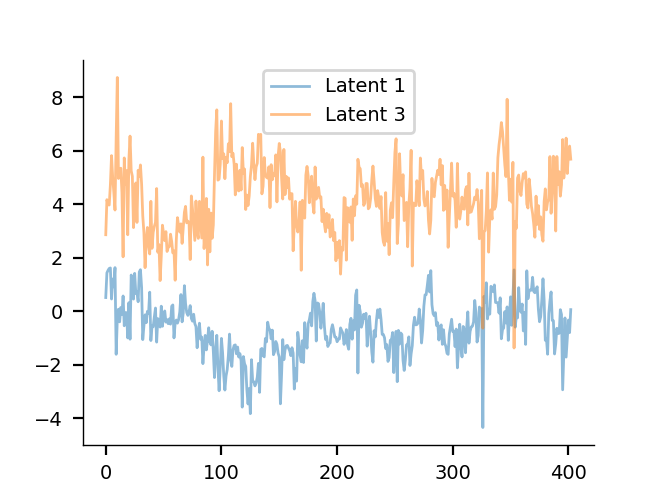

In [37]:
bah(ax0=0, ax1=2, num_latents=3)

Latent 1 and Latent 2 are equal, aborting
Latent 1 and Latent 3 are equal, aborting
Latent 1 and Latent 4 are equal, aborting
Latent 2 and Latent 3 are equal, aborting
Latent 2 and Latent 4 are equal, aborting
Latent 3 and Latent 4 are equal, aborting
Latent 5 and Latent 6 are equal, aborting


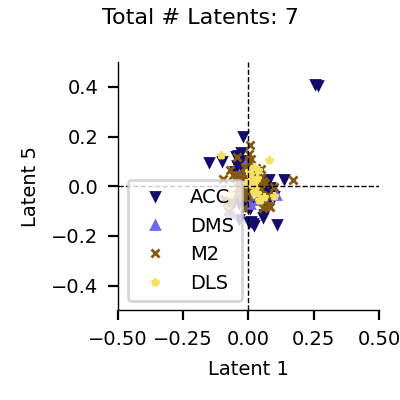

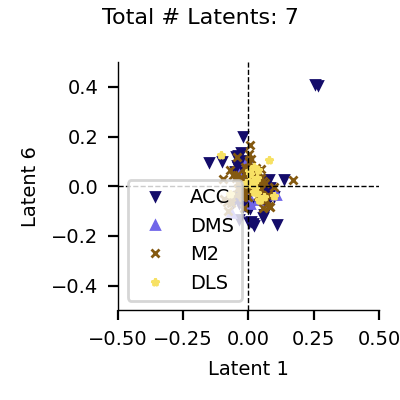

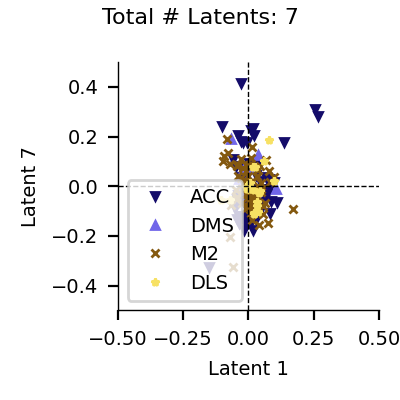

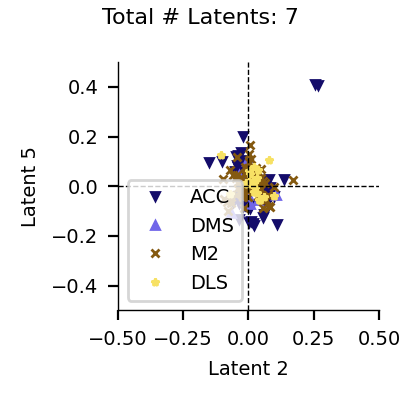

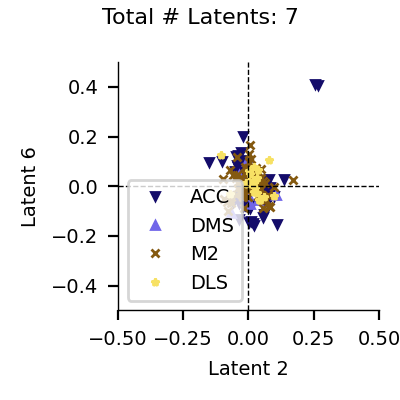

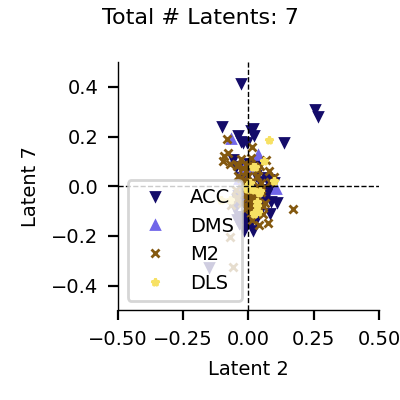

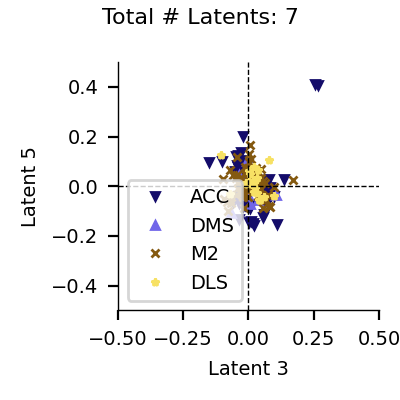

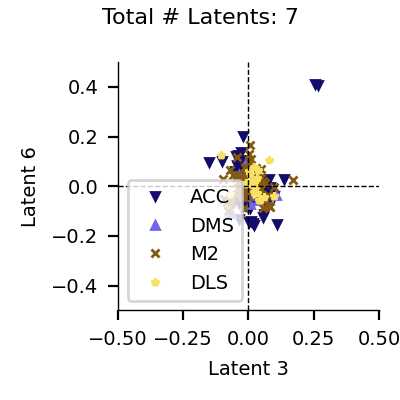

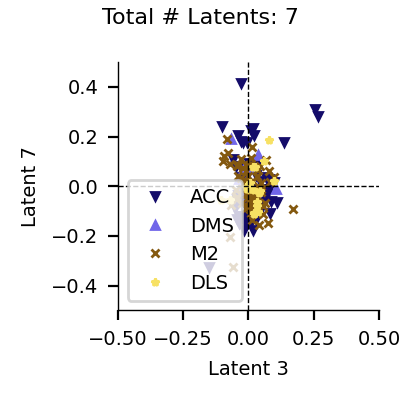

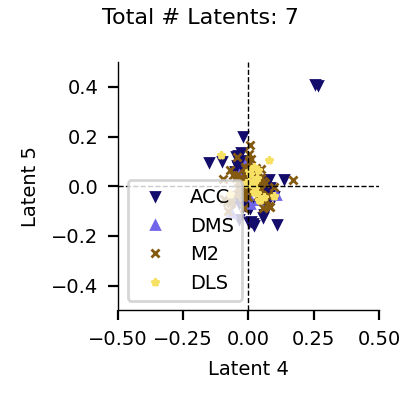

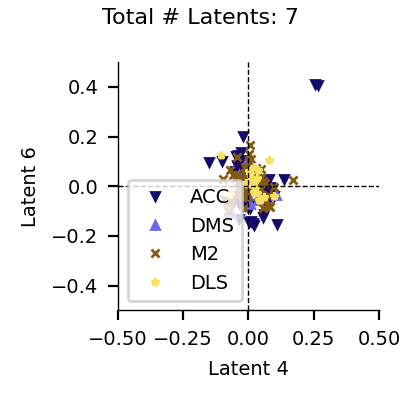

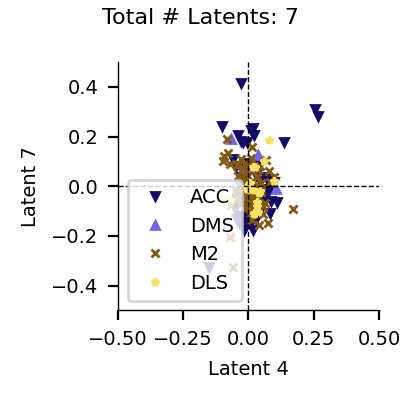

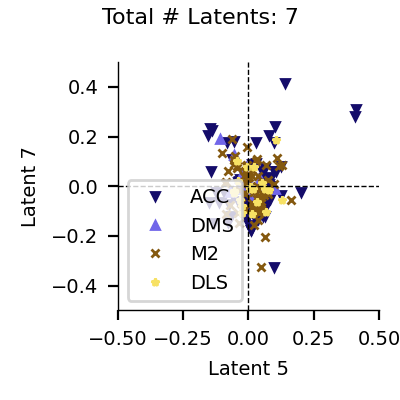

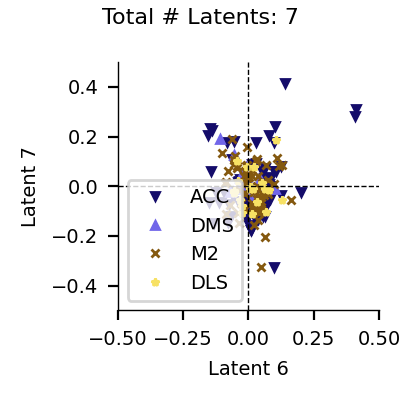

In [ ]:
# latents = 7 (3 uniques)
for ax0 in range(7):
    for ax1 in range(7):
        if not ax0>=ax1: foo(ax0=ax0, ax1=ax1, num_latents=7)

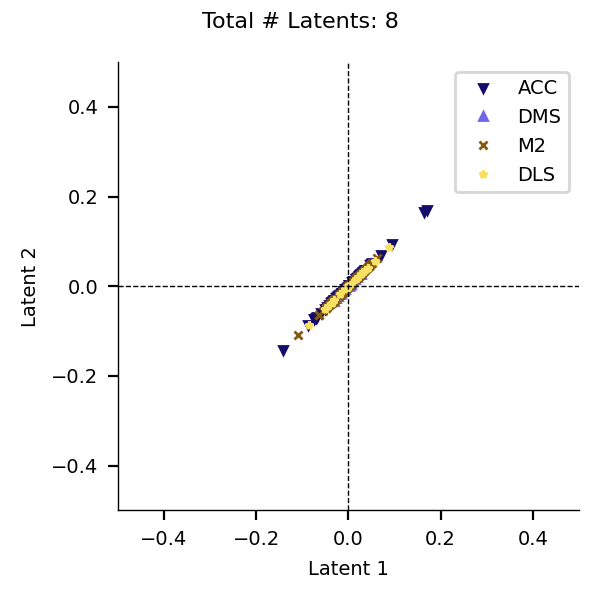

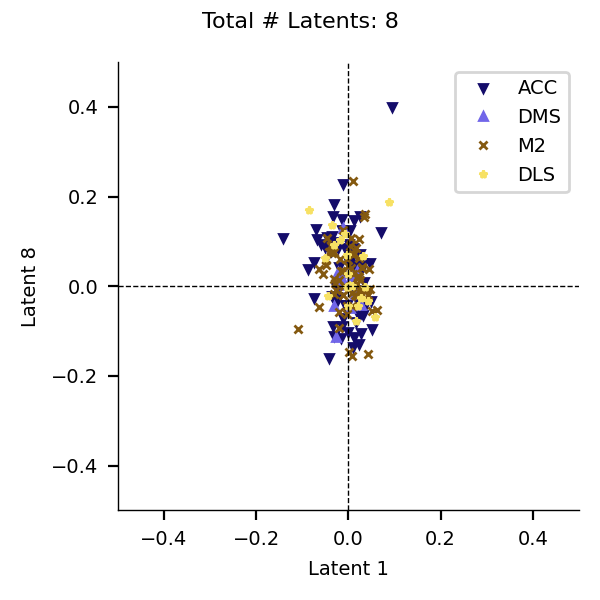

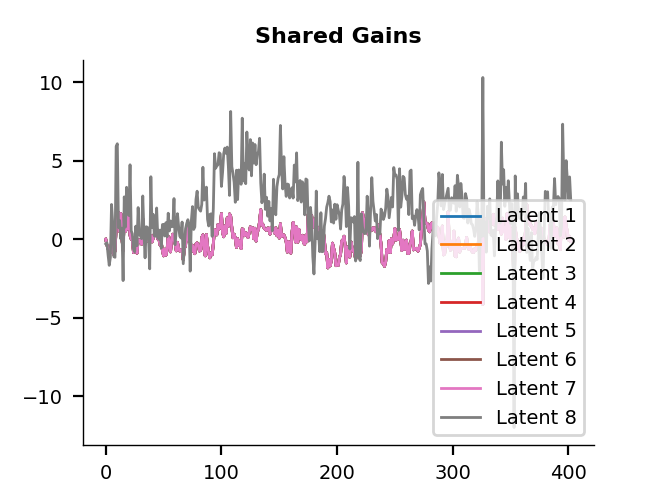

In [24]:
foo(ax0=0, ax1=1, num_latents=8, abort=False)
foo(ax0=0, ax1=7, num_latents=8)

num_latents=8

plt.figure()
for ax in range(8):
    plt.plot(das[num_latents-1]['affine']['model'].gain_mu.get_weights()[:,ax], label=f"Latent {ax+1}")
    
plt.title("Shared Gains")
plt.legend()

Latent 1 and Latent 2 are equal, aborting
Latent 1 and Latent 3 are equal, aborting
Latent 1 and Latent 4 are equal, aborting
Latent 1 and Latent 5 are equal, aborting
Latent 1 and Latent 6 are equal, aborting
Latent 1 and Latent 7 are equal, aborting
Latent 2 and Latent 3 are equal, aborting
Latent 2 and Latent 4 are equal, aborting
Latent 2 and Latent 5 are equal, aborting
Latent 2 and Latent 6 are equal, aborting
Latent 2 and Latent 7 are equal, aborting
Latent 3 and Latent 4 are equal, aborting
Latent 3 and Latent 5 are equal, aborting
Latent 3 and Latent 6 are equal, aborting
Latent 3 and Latent 7 are equal, aborting
Latent 4 and Latent 5 are equal, aborting
Latent 4 and Latent 6 are equal, aborting
Latent 4 and Latent 7 are equal, aborting
Latent 5 and Latent 6 are equal, aborting
Latent 5 and Latent 7 are equal, aborting
Latent 6 and Latent 7 are equal, aborting


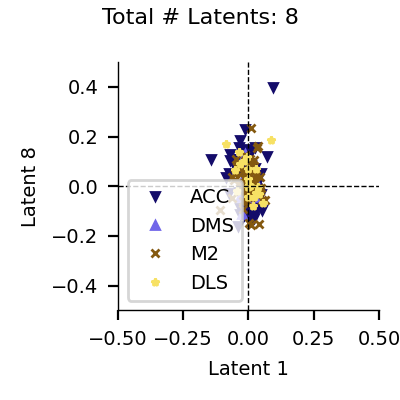

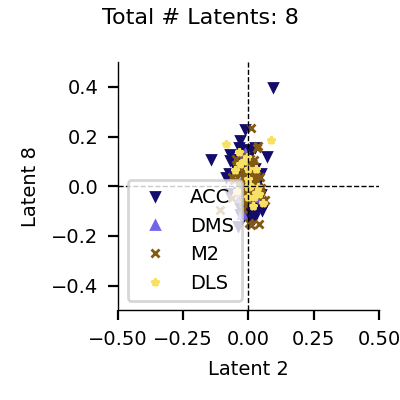

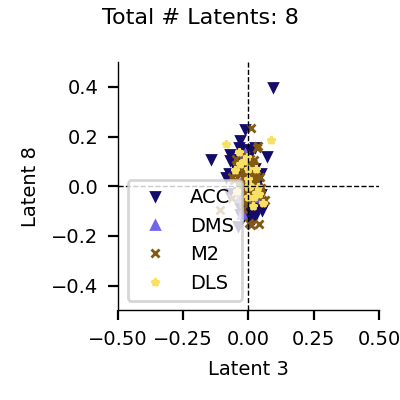

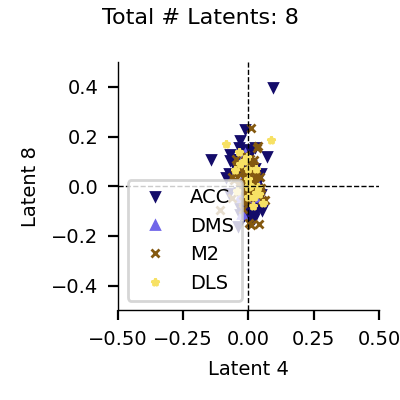

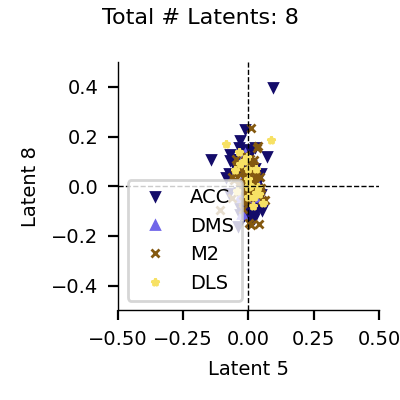

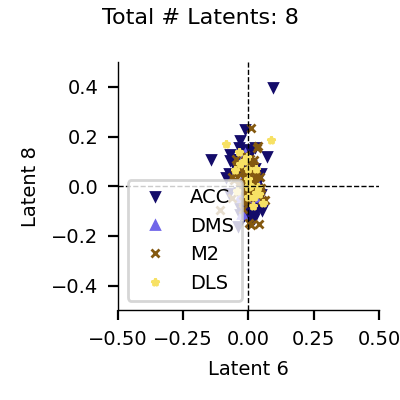

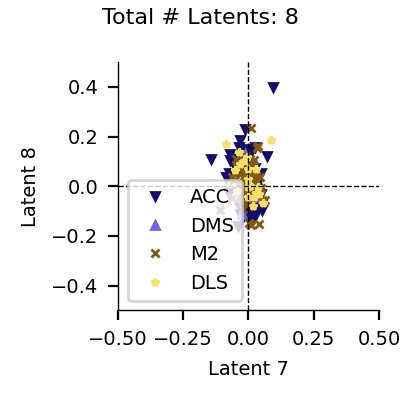

In [16]:
# latents = 8
for ax0 in range(8):
    for ax1 in range(8):
        if not ax0>=ax1: foo(ax0=ax0, ax1=ax1, num_latents=8)

### NB 

In [9]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [5]:
psths, _, _, _, _, _, mask = data.get_psths(unit_spike_times, trial_data, session_data, regions, 
                                tpre=0.5, tpost=0.5, binwidth_ms=25, alignment='choice', 
                            balance=True, reward_only=False, do_rem_zstd=True, shuffle=False, prev_filter=False)
trial_data = trial_data[mask]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_gd, train_dl, val_dl, test_dl, train_inds, val_inds, test_inds, Mtrain, Mtest, sample, num_trials, num_tv, num_units = fitlvm_utils.get_data_model(psths, trial_data, regions, norm=False, num_tents=2, task_vars=['response', 'rewarded', 'response_prev', 'rewarded_prev'])

0 291 96 16
originally 188 units
good units 188
403 Trials, 188 Neurons


Step 0
Found 85 /188 units with stable low-dimensional structure at rank 1
Step 1: Baseline
Fitting baseline model...done
Step 2: Task Var
Fitting task variable model...done
Step 2a: Eval
as expected
as expected


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Step3a: Inclusion Criteria
Found 169 /188 units with significant task variable + drift model
187 187
Using 174 total units for modeling


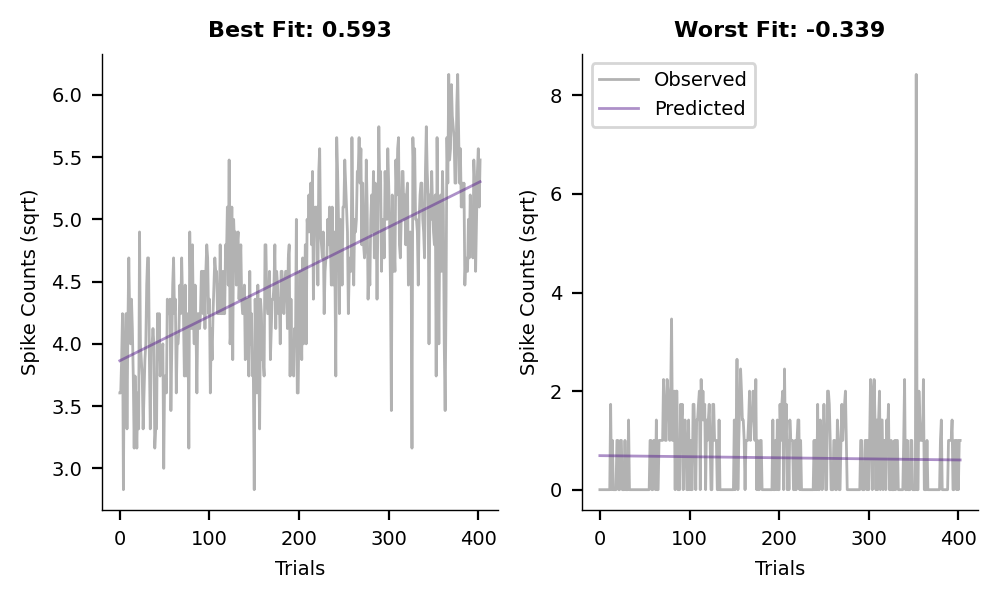

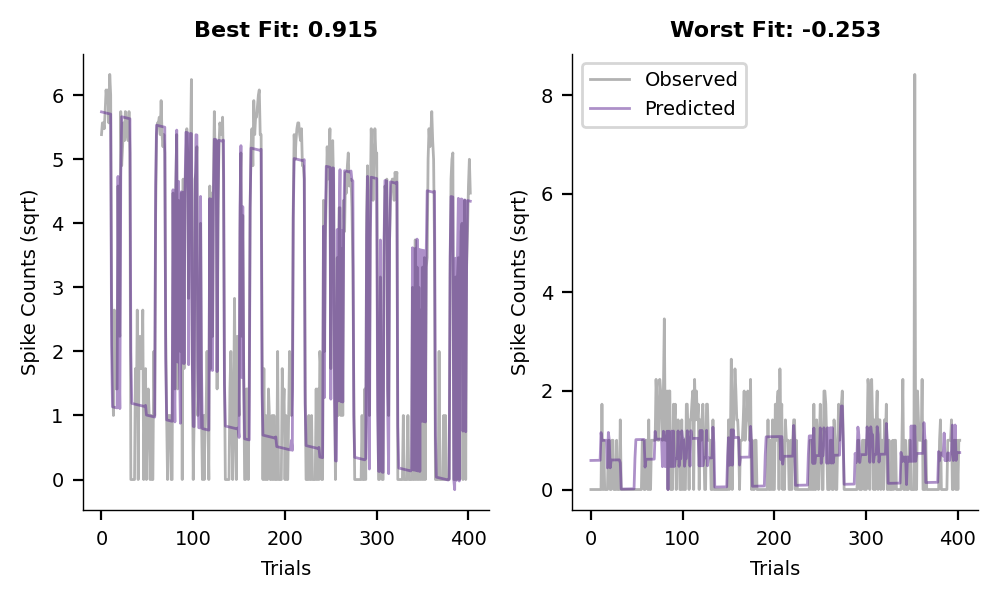

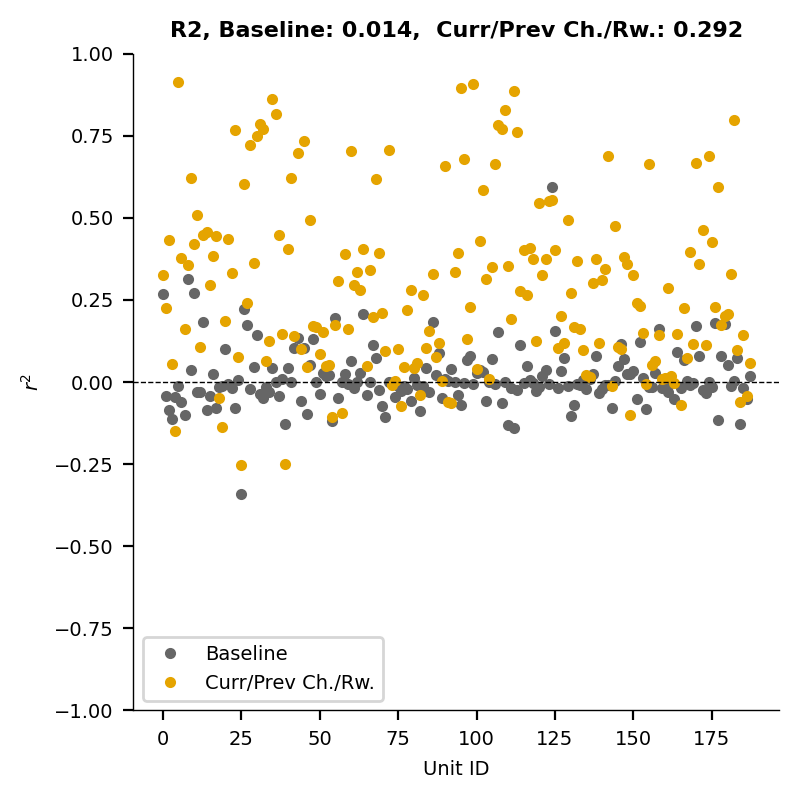

In [6]:
# MODELING
# Step 0: Check if dataset has stable low-dim structure at 4+ dims
print("Step 0")
cids_pca = fitlvm_utils.check_stable_lowd(data_gd, Mtrain, Mtest, num_units)

# Step 1: Fit baseline model
# > Baseline model: has no task vars, can capture slow drift in firing rate for each unit using b0-splines
print("Step 1: Baseline")
mod_baseline = fitlvm_utils.fit_baseline(train_dl, val_dl, num_tv, num_units, ntents=2)

# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
print("Step 2: Task Var")
mod_tv = fitlvm_utils.fit_tvs(train_dl, val_dl, num_tv, num_units, mod_baseline) 

# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_baseline        = fitlvm_utils.eval_model(mod_baseline, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_baseline, res_tv, label_a="Baseline", label_b="Curr/Prev Ch./Rw.", save=False)

# Step 3a: Get units that had significant performance increase with a task variable model
print("Step3a: Inclusion Criteria")
cids = fitlvm_utils.get_cids(cids_pca, res_tv)

In [7]:
# Step 3b: Fit gain autoencoder
print("Step 3b: Gain AE")
mod_ae_gain = fitlvm_utils.fit_ae_gain(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=2) 

# Step 3c: Fit offset autoencoder
print("Step 3c: Offset AE")
mod_ae_offset = fitlvm_utils.fit_ae_offset(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=2)

# Step 3d: Fit affine autoencoder
print("Step 3d: Affine AE")
mod_ae_affine, r2 = fitlvm_utils.fit_ae_affine(train_dl, val_dl, test_dl, mod_tv, mod_ae_gain, mod_ae_offset, cids, num_tv, num_units, data_gd, device, num_latents=2)


Step 3b: Gain AE
here because include_gain=True
Fitting gain autoencoder...Initial: -5.5782
Fit latents: -5.5782, 0.3856
0) fit task vars: -5.5782, 0.3549
0) fit latents: 0.3549, 0.3703
1) fit task vars: 0.3703, 0.3654
breaking because tolerance was hit
Done
Step 3c: Offset AE
Fitting offset autoencoder...
Initial: -2.7045
Fit latents: -2.7045, 0.3920
0) fit task vars: -2.7045, 0.3660
0) fit latents: 0.3660, 0.3769
1) fit task vars: 0.3769, 0.3708
breaking because tolerance was hit
Done
Step 3d: Affine AE
here because include_gain=True
<class 'lib.models.SharedGain'> <class 'lib.models.SharedGain'>
Fitting affine autoencoder...Initial: -1.3816
Fit latents: -1.3816, 0.4099
0) fit task vars: -1.3816, 0.3861
0) fit latents: 0.3861, 0.3912
1) fit task vars: 0.3912, 0.3933
1) fit latents: 0.3933, 0.3976
2) fit task vars: 0.3976, 0.3995
2) fit latents: 0.3995, 0.4002
3) fit task vars: 0.4002, 0.4012
3) fit latents: 0.4012, 0.4011
breaking because tolerance was hit
Done
Autoencoder iter 0, va

In [11]:
# Step 3e: Convert ae to lvm
# print("Step 3e: AE to LVM")
# mod_ae_offset, mod_ae_gain, mod_ae_affine = fitlvm_utils.ae2lvm(train_dl, val_dl, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, num_tv, num_units, data_gd, num_latents=2)

# Step 4: Fit affine model
print("Step 4: Fit Affine")
mod_affine = fitlvm_utils.fit_affine(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=2)

# # Step 5a: Fit gain only
# print("Step 5a: Fit gain only")
# mod_gain = fitlvm_utils.fit_gain(mod_ae_gain, mod_affine, train_dl, val_dl, cids, num_tv, num_units, data_gd, ntents=2, num_latents=2)

# # Step 5b: Fit offset only
# print("Step 5b: Fit offset only")
# mod_offset = fitlvm_utils.fit_offset(train_dl, val_dl, mod_ae_affine, mod_affine, cids, num_tv, num_units, data_gd, num_latents=2)

Step 4: Fit Affine
Fitting Affine Model...Initial: 0.3238
Initial: 0.3238
Fit latents: 0.3238, 0.3214
0) fit stim: 0.3238, 0.3328
0) fit latents: 0.3328, 0.3774
1) fit stim: 0.3774, 0.3764
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3774, train loss = 0.5529
Initial: 0.3238
Initial: 0.3238
Fit latents: 0.3238, 0.3692
0) fit stim: 0.3238, 0.3458
0) fit latents: 0.3458, 0.3809
1) fit stim: 0.3809, 0.3778
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3809, train loss = 0.5555
Initial: 0.3238
Initial: 0.3238
Fit latents: 0.3238, 0.3830
0) fit stim: 0.3238, 0.3656
0) fit latents: 0.3656, 0.3864
1) fit stim: 0.3864, 0.3816
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3864, train loss = 0.5540
Initial: 0.3238
Initial: 0.3238
Fit latents: 0.3238, 0.3923
0) fit stim: 0.3238, 0.3615
0) fit latents: 0.3615, 0.3857
1) fit stim: 0.3857, 0.3786
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3857, train loss = 0.5900
Done


In [ ]:
# model = das_sess['affine']['model']
# zgain = model.gain_mu.get_weights()
# zweight = model.readout_gain.get_weights()

In [ ]:
# model.readout_gain.input_dims

[1, 1, 1, 1]

In [14]:
# EVALUATION
print("Evaluating...")# EVALUATION
# das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine, mod_affine, mod_gain, mod_offset, cids, data_gd, do_save=False, do_plot=True)
das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine, mod_affine, [], [], cids, data_gd, do_save=False, do_plot=True)

Evaluating...
as expected
as expected
as expected
checkpoint 2
as expected
checkpoint 1
as expected
checkpoint 1
checkpoint 2
Fitting CV PCA


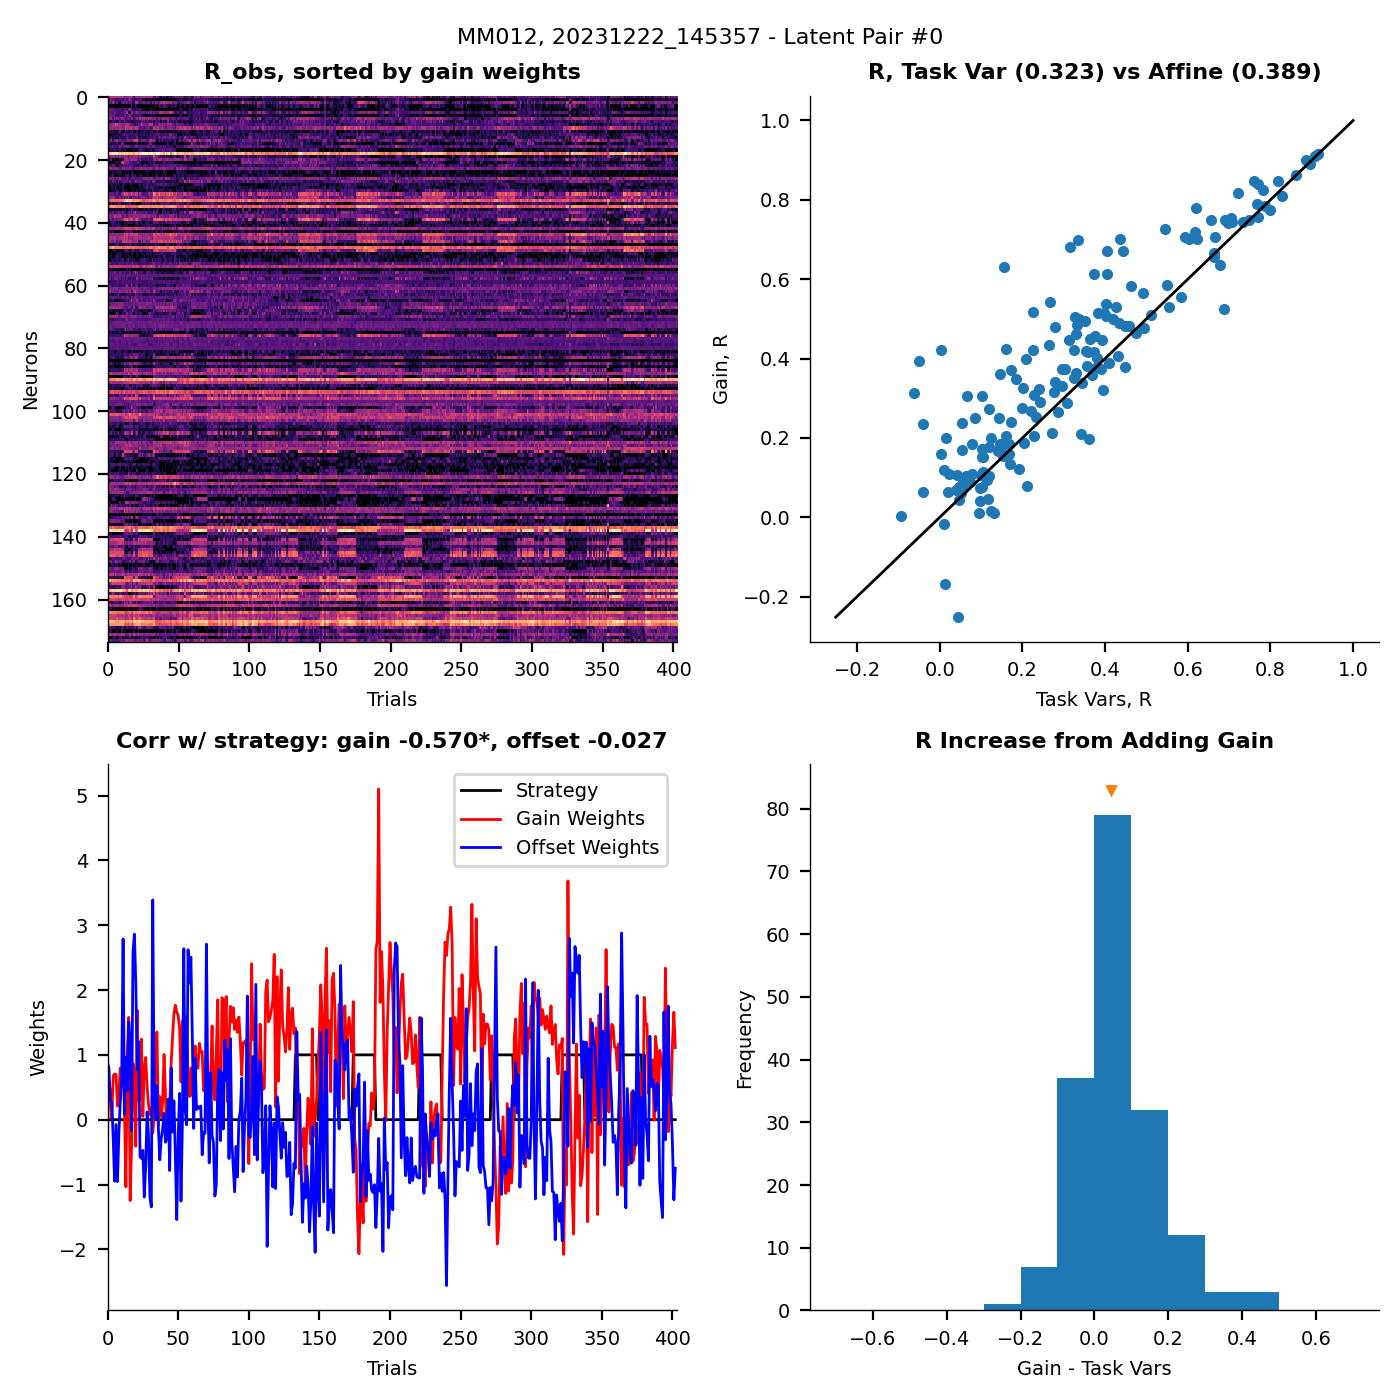

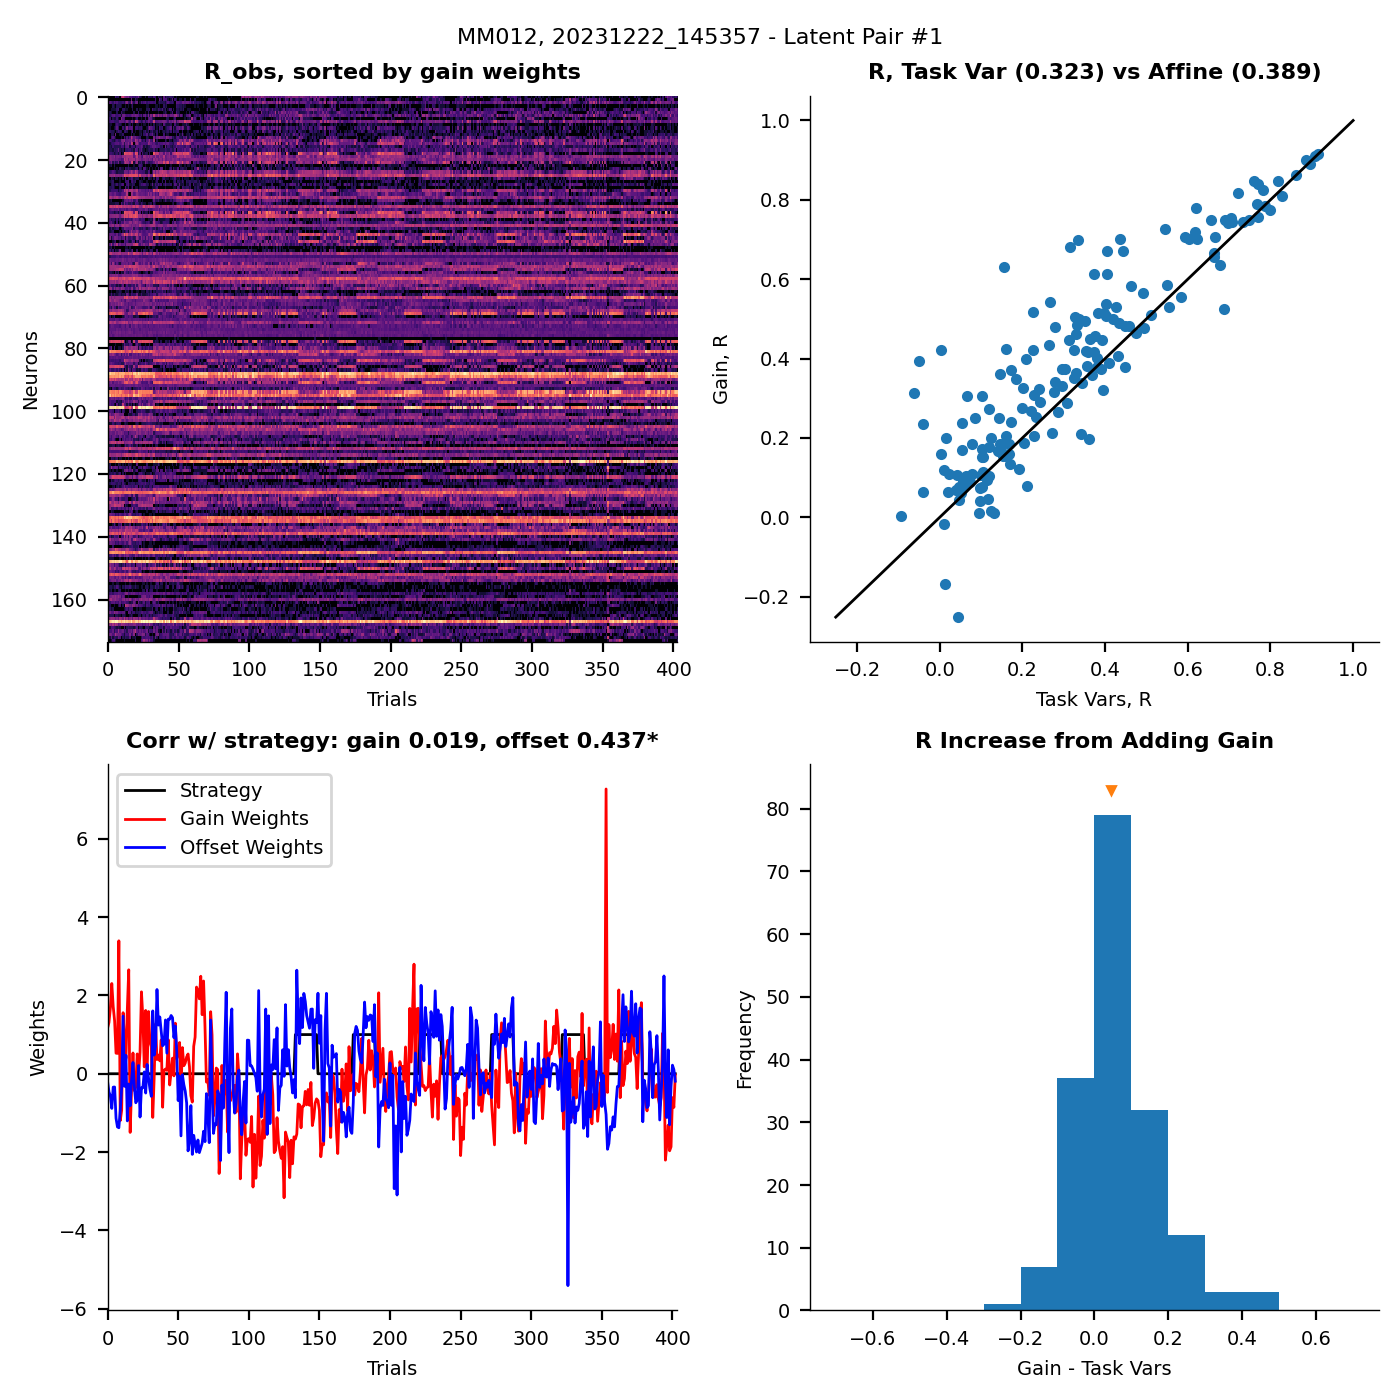

In [28]:
_ = fitlvm_utils.plot_summary(das_sess, subj_idx=0, sess_idx=3)